# Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ******************
# Styles
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes
# ******************


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ml_projects/2_nlp_task/tripadvisor_hotel_reviews.csv")

In [ ]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
df.shape

(20491, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,20491.0,3.952223,1.23303,1.0,3.0,4.0,5.0,5.0


In [ ]:
df["Rating"].value_counts(normalize=True)*100 #shows the percentage of each class available

5    44.185252
4    29.471475
3    10.658338
2     8.750183
1     6.934752
Name: Rating, dtype: float64

# Data Visualization

In [ ]:
def sanity_check(): # for a sanity check that labels match the text
  for label in range(5):
    print("printing 2 reviews for the label class:", label+1)
    for i in range(2):
      print(df[df["Rating"] == (label+1)].head(2)["Review"].iloc[i])
    print()

In [ ]:
sanity_check()

printing 2 reviews for the label class: 1
horrible customer service hotel stay february 3rd 4th 2007my friend picked hotel monaco appealing website online package included champagne late checkout 3 free valet gift spa weekend, friend checked room hours earlier came later, pulled valet young man just stood, asked valet open said, pull bags didn__Ç_é_ offer help, got garment bag suitcase came car key room number says not valet, car park car street pull, left key working asked valet park car gets, went room fine bottle champagne oil lotion gift spa, dressed went came got bed noticed blood drops pillows sheets pillows, disgusted just unbelievable, called desk sent somebody 20 minutes later, swapped sheets left apologizing, sunday morning called desk speak management sheets aggravated rude, apparently no manager kind supervisor weekend wait monday morning, young man spoke said cover food adding person changed sheets said fresh blood rude tone, checkout 3pm package booked, 12 1:30 staff maid

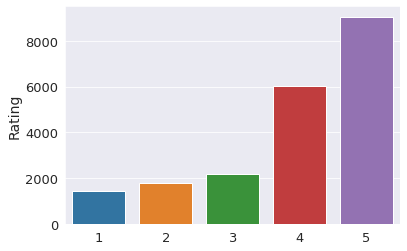

In [ ]:
sns.barplot(x = df["Rating"].value_counts().index, y = df["Rating"].value_counts())
# A bar graph of class distribution in the dataset. 
# Each bar depicts the number of records belonging to a particular class in the dataset

In [ ]:
# Shapes of train, test and validation data are printed in next section

# Data Preprocessing

In [ ]:
from tensorflow import keras
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")

In [ ]:
df = df.sample(frac = 1)
X = df["Review"]
y = df["Rating"]
df.shape

(20491, 2)

In [ ]:
y = y-1 #shifting classes by 1 => class 1 value is now 0, class2 value is now 1 and so on

In [ ]:
embeddingsX = embed(X) # convert a list of sentences to vectors

In [ ]:
arX = np.array(embeddingsX)

In [ ]:
arX.shape

(20491, 128)

In [ ]:
X_training_full = arX[:16392] #80% of complete data (20491 instances * .8 = 16392)
y_training_full = y[:16392]

X_test = arX[16392:]
y_test = y[16392:]

X_train = X_training_full[:12000]
y_train = y_training_full[:12000]

X_valid = X_training_full[12000:]
y_valid = y_training_full[12000:]

In [ ]:
# Printing the shapes of the train and test data
print(X_train.shape)
print(y_train.shape)

print(X_valid.shape)
print(y_valid.shape)

print(X_test.shape)
print(y_test.shape)

(12000, 128)
(12000,)
(4392, 128)
(4392,)
(4099, 128)
(4099,)


# HyperParameter Tuning

In [ ]:
from timeit import default_timer as timer

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

cb = TimingCallback() # callback for printing the total time taken for training

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
 restore_best_weights=True) # callback for stopping early

In [ ]:
def build_model(hidden_layers = 5, n_neurons=30, learning_rate=3e-3, input_shape=[128,]):
  model = keras.models.Sequential()
  options = {"input_shape": input_shape}
  for i in range(hidden_layers):
    model.add(keras.layers.Dense(n_neurons, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01),  **options))
    options = {}

  model.add(keras.layers.Dropout(rate=0.2))
   

  model.add(keras.layers.Dense(5, activation="softmax",  **options))

  # optimizer = keras.optimizers.SGD(learning_rate)
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return model

In [ ]:
keras_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model) #we will first do some hyperparameter tuning

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
param_distribs = { #parameters that we want to tune
  "hidden_layers": [5, 6, 7],
  "n_neurons": np.arange(1, 128),
  "learning_rate": reciprocal(3e-4, 3e-2),
}
rnd_search_cv = RandomizedSearchCV(keras_clf, param_distribs, n_iter=5, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=1000,
 validation_data=(X_valid, y_valid),
 callbacks=[keras.callbacks.EarlyStopping(patience=10)])


Epoch 1/1000
250/250 [==============================] - 2s 4ms/step - loss: 2.1478 - accuracy: 0.4482 - val_loss: 1.3206 - val_accuracy: 0.4775
Epoch 2/1000
250/250 [==============================] - 1s 3ms/step - loss: 1.2465 - accuracy: 0.4938 - val_loss: 1.1767 - val_accuracy: 0.5064
Epoch 3/1000
250/250 [==============================] - 1s 4ms/step - loss: 1.1928 - accuracy: 0.5116 - val_loss: 1.1485 - val_accuracy: 0.5430
Epoch 4/1000
250/250 [==============================] - 1s 3ms/step - loss: 1.1720 - accuracy: 0.5150 - val_loss: 1.1440 - val_accuracy: 0.5335
Epoch 5/1000
250/250 [==============================] - 1s 4ms/step - loss: 1.1575 - accuracy: 0.5170 - val_loss: 1.1469 - val_accuracy: 0.5282
Epoch 6/1000
250/250 [==============================] - 2s 7ms/step - loss: 1.1511 - accuracy: 0.5220 - val_loss: 1.1210 - val_accuracy: 0.5437
Epoch 7/1000
250/250 [==============================] - 2s 10ms/step - loss: 1.1441 - accuracy: 0.5261 - val_loss: 1.1124 - val_accuracy

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fa814bc9310>,
                   n_iter=5,
                   param_distributions={'hidden_layers': [5, 6, 7],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa8143611d0>,
                                        'n_neurons': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 10

In [ ]:
rnd_search_cv.best_params_ #these are the appropriate parameters that we should be using

{'hidden_layers': 6, 'learning_rate': 0.0005270791657748539, 'n_neurons': 77}

In [ ]:
rnd_search_cv.best_score_


0.5465833147366842

# Model 1

## Model Building and Compilation

In [ ]:
# we will use results of our hyperparameter tuning
def build_model(hidden_layers = 5, n_neurons=30, learning_rate=3e-3, input_shape=[128,]):
  model = keras.models.Sequential()
  options = {"input_shape": input_shape}
  for i in range(hidden_layers):
    model.add(keras.layers.Dense(n_neurons, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01),  **options))
    options = {}

  model.add(keras.layers.Dropout(rate=0.2))
   

  model.add(keras.layers.Dense(5, activation="softmax",  **options))

  # optimizer = keras.optimizers.SGD(learning_rate)
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return model

In [ ]:
model1 = build_model(hidden_layers = 6, n_neurons=77, learning_rate= 0.0005270791657748539)
# here we build the model where for each hidden layer appropriate number of hidden units are 77 (result of hyperparameter tuning)
# in the build model we have done l1 regularization
# we have added a dropout layer at the end, it further helps in regularization the output in direct sense
# there the loss function is sparse_categorical_crossentropy
# we have used Adam optimizer and learning rate has been decided by hyperparameter tuning which is 0.0005270791657748539
# we have used accuracy as a metric there


In [ ]:
model1.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_168 (Dense)           (None, 77)                9933      
                                                                 
 dense_169 (Dense)           (None, 77)                6006      
                                                                 
 dense_170 (Dense)           (None, 77)                6006      
                                                                 
 dense_171 (Dense)           (None, 77)                6006      
                                                                 
 dense_172 (Dense)           (None, 77)                6006      
                                                                 
 dense_173 (Dense)           (None, 77)                6006      
                                                                 
 dropout_24 (Dropout)        (None, 77)              

## Model Training

In [ ]:
history = model1.fit(X_train, y_train, 
                    epochs=1000, batch_size = 32,
                    validation_data=(X_valid, y_valid),
                    callbacks=[cb, keras.callbacks.EarlyStopping(patience=10)]) #training the model

Epoch 1/1000
375/375 [==============================] - 2s 4ms/step - loss: 2.8347 - accuracy: 0.4702 - val_loss: 1.4646 - val_accuracy: 0.4975
Epoch 2/1000
375/375 [==============================] - 1s 3ms/step - loss: 1.3119 - accuracy: 0.5125 - val_loss: 1.2336 - val_accuracy: 0.5027
Epoch 3/1000
375/375 [==============================] - 1s 4ms/step - loss: 1.2049 - accuracy: 0.5149 - val_loss: 1.1689 - val_accuracy: 0.5239
Epoch 4/1000
375/375 [==============================] - 1s 4ms/step - loss: 1.1744 - accuracy: 0.5232 - val_loss: 1.1522 - val_accuracy: 0.5196
Epoch 5/1000
375/375 [==============================] - 1s 4ms/step - loss: 1.1578 - accuracy: 0.5236 - val_loss: 1.1447 - val_accuracy: 0.5194
Epoch 6/1000
375/375 [==============================] - 1s 4ms/step - loss: 1.1501 - accuracy: 0.5222 - val_loss: 1.1299 - val_accuracy: 0.5289
Epoch 7/1000
375/375 [==============================] - 1s 4ms/step - loss: 1.1400 - accuracy: 0.5277 - val_loss: 1.1216 - val_accuracy:

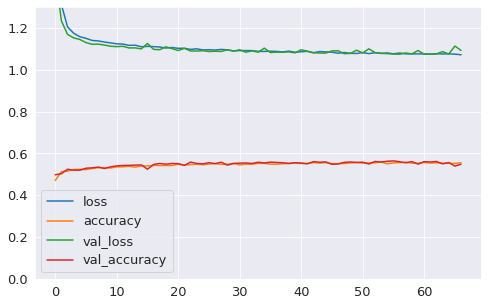

In [ ]:
def plot_history_graphs(history): # for plotting the loss and accuracy history graphs for both train and validation set
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, 1.3) # set the vertical range to [0-1.3]
  plt.show()

plot_history_graphs(history)

In [ ]:
print(cb.logs)

[2.29786635000346, 1.490160597000795, 1.8050564209988806, 1.5251740160019835, 1.336213732000033, 1.4352345739971497, 1.464642120001372, 1.4422860449994914, 1.734928295998543, 1.9325010209940956, 1.3514048500001081, 1.4829372960011824, 1.3318479710069369, 1.3377061979990685, 1.4112146029947326, 1.4930358940036967, 2.081325469996955, 2.9878222160041332, 2.6641138790000696, 1.5070540750020882, 1.5230687980001676, 1.4473879120050697, 2.498962402998586, 3.4357699649990536, 1.6943249779942562, 1.5022588779975194, 1.5163430780012277, 1.4886256919999141, 1.4493194770038826, 1.3052905610020389, 1.415526585005864, 1.435880532997544, 1.3352196969935903, 1.3450537149983575, 1.4441076570001314, 1.3202086230012355, 1.3227378829978989, 1.3578030520002358, 1.424127200996736, 1.3512925430040923, 1.332168039996759, 1.4878575960028684, 1.4503391930047655, 1.4317929030003143, 1.3720220579998568, 1.4472138929995708, 1.4210904060018947, 2.26774470199598, 2.1707338809937937, 2.4407478980065207, 1.96616238999

In [ ]:
print(sum(cb.logs)) #time taken for training

681.6516932701415


## Model Evaluation

In [ ]:
loss_accuracy = pd.DataFrame(history.history)

In [ ]:
loss_accuracy

,loss,accuracy,val_loss,val_accuracy
0,2.834716,0.470167,1.464563,0.497495
1,1.311925,0.512500,1.233635,0.502732
2,1.204852,0.514917,1.168855,0.523907
3,1.174437,0.523250,1.152244,0.519581
4,1.157837,0.523583,1.144682,0.519353
...,...,...,...,...
62,1.076340,0.554583,1.075508,0.561248
63,1.075405,0.552667,1.086789,0.549863
64,1.076019,0.552583,1.075008,0.556011
65,1.074410,0.552000,1.113192,0.538934


In [ ]:
loss_accuracy.iloc[-1] # Printing the final train and validation loss and accuracy

loss            1.071620
accuracy        0.554917
val_loss        1.092054
val_accuracy    0.547814
Name: 66, dtype: float64

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
y_predictions = model1.predict(X_valid)

In [ ]:
y_predictions

array([[1.5844715e-01, 2.9502913e-01, 2.6180136e-01, 2.1977355e-01,
        6.4948760e-02],
       [5.8660964e-03, 4.2947337e-02, 1.4039265e-01, 4.4154146e-01,
        3.6925238e-01],
       [7.1242740e-03, 4.8827533e-02, 1.4989062e-01, 4.4233388e-01,
        3.5182369e-01],
       ...,
       [7.4847398e-05, 2.1614595e-03, 2.5604974e-02, 2.8697360e-01,
        6.8518513e-01],
       [4.1586900e-05, 1.4408500e-03, 2.0090358e-02, 2.6219466e-01,
        7.1623248e-01],
       [3.2867674e-02, 1.2873793e-01, 2.3195104e-01, 3.9898825e-01,
        2.0745519e-01]], dtype=float32)

In [ ]:
y_predict = []
for i in range(len(y_predictions)):
  y_predict.append(np.argmax(y_predictions[i]))

In [ ]:
print(len(y_predict))
print(len(y_valid))

4392
4392


In [ ]:
print(classification_report(y_valid, y_predict, target_names=["rating_1", "rating_2", "rating_3", "rating_4", "rating_5"]))
print(confusion_matrix(y_valid, y_predict))

              precision    recall  f1-score   support

    rating_1       0.56      0.66      0.61       292
    rating_2       0.42      0.30      0.35       399
    rating_3       0.20      0.01      0.02       463
    rating_4       0.40      0.30      0.34      1333
    rating_5       0.62      0.89      0.73      1905

    accuracy                           0.55      4392
   macro avg       0.44      0.43      0.41      4392
weighted avg       0.49      0.55      0.49      4392

[[ 192   53    2   37    8]
 [ 113  121   16  126   23]
 [  24   73    6  237  123]
 [  11   35    4  398  885]
 [   1    9    2  204 1689]]


In [ ]:
#if we see the f1-score, we find 0.73 is the maximum (which belongs to class rating_5) 
#and 0.02 is minimum (which belongs to class rating_3)
print("So the best class is rating_5 and worst class is rating_3")

So the best class is rating_5 and worst class is rating_3


In [ ]:
y_predictions

array([[1.5844715e-01, 2.9502913e-01, 2.6180136e-01, 2.1977355e-01,
        6.4948760e-02],
       [5.8660964e-03, 4.2947337e-02, 1.4039265e-01, 4.4154146e-01,
        3.6925238e-01],
       [7.1242740e-03, 4.8827533e-02, 1.4989062e-01, 4.4233388e-01,
        3.5182369e-01],
       ...,
       [7.4847398e-05, 2.1614595e-03, 2.5604974e-02, 2.8697360e-01,
        6.8518513e-01],
       [4.1586900e-05, 1.4408500e-03, 2.0090358e-02, 2.6219466e-01,
        7.1623248e-01],
       [3.2867674e-02, 1.2873793e-01, 2.3195104e-01, 3.9898825e-01,
        2.0745519e-01]], dtype=float32)

In [ ]:
corresponding_probability = []
for i in range(len(y_valid)):
  corresponding_probability.append(y_predictions[i][y_valid.iloc[i]])

In [ ]:
print(len(np.array(y_valid)))
print(len(corresponding_probability))
print(len(y_predict))

4392
4392
4392


In [ ]:
data = {
    'Real_Class':np.array(y_valid),
     "Probability": corresponding_probability, 
     "Predicted_Class": y_predict
}

In [ ]:
dfi = pd.DataFrame(data)

In [ ]:
dfi[dfi["Real_Class"] == 0].sort_values(by=['Probability'], ascending=True).head(2) #the two most incorrectly classified records 

,Real_Class,Probability,Predicted_Class
4359,0,0.000033,4
2259,0,0.000061,4


In [ ]:
dfi[dfi["Real_Class"] == 1].sort_values(by=['Probability'], ascending=True).head(2) #the two most incorrectly classified records 

,Real_Class,Probability,Predicted_Class
3064,1,0.000766,4
4016,1,0.001993,4


In [ ]:
dfi[dfi["Real_Class"] == 2].sort_values(by=['Probability'], ascending=True).head(2) #the two most incorrectly classified records 

,Real_Class,Probability,Predicted_Class
3622,2,0.006964,4
2614,2,0.009415,4


In [ ]:
dfi[dfi["Real_Class"] == 3].sort_values(by=['Probability'], ascending=True).head(2) #the two most incorrectly classified records 

,Real_Class,Probability,Predicted_Class
1730,3,0.014415,0
13,3,0.017657,0


In [ ]:
dfi[dfi["Real_Class"] == 4].sort_values(by=['Probability'], ascending=True).head(2) #the two most incorrectly classified records 

,Real_Class,Probability,Predicted_Class
3587,4,0.007299,0
335,4,0.015842,1


# Model 2

## Model Building and Compilation

In [ ]:
# we will use results of our hyperparameter tuning
def build_model(hidden_layers = 5, n_neurons=30, learning_rate=3e-3, input_shape=[128,]):
  model = keras.models.Sequential()
  options = {"input_shape": input_shape}
  for i in range(hidden_layers):
    model.add(keras.layers.Dense(n_neurons, activation="relu",  **options))
    options = {}

  model.add(keras.layers.Dropout(rate=0.2))
   

  model.add(keras.layers.Dense(5, activation="softmax",  **options))

  # optimizer = keras.optimizers.SGD(learning_rate)
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return model

In [ ]:
model2 = build_model(hidden_layers = 6, n_neurons=77, learning_rate= 0.0005270791657748539)
# here we build the model where for each hidden layer appropriate number of hidden units are 77 (result of hyperparameter tuning)
# we have added a dropout layer at the end, it further helps in regularization the output in direct sense
# there the loss function is sparse_categorical_crossentropy
# we have used Adam optimizer and learning rate has been decided by hyperparameter tuning which is 0.0005270791657748539
# we have used accuracy as a metric there


In [ ]:
model2.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_175 (Dense)           (None, 77)                9933      
                                                                 
 dense_176 (Dense)           (None, 77)                6006      
                                                                 
 dense_177 (Dense)           (None, 77)                6006      
                                                                 
 dense_178 (Dense)           (None, 77)                6006      
                                                                 
 dense_179 (Dense)           (None, 77)                6006      
                                                                 
 dense_180 (Dense)           (None, 77)                6006      
                                                                 
 dropout_25 (Dropout)        (None, 77)              

## Model Training

In [ ]:
history = model2.fit(X_train, y_train, 
                    epochs=1000, batch_size = 32,
                    validation_data=(X_valid, y_valid),
                    callbacks=[cb, keras.callbacks.EarlyStopping(patience=10)]) #training the model

Epoch 1/1000
375/375 [==============================] - 2s 4ms/step - loss: 1.1290 - accuracy: 0.4978 - val_loss: 1.0175 - val_accuracy: 0.5435
Epoch 2/1000
375/375 [==============================] - 1s 4ms/step - loss: 1.0026 - accuracy: 0.5477 - val_loss: 1.0017 - val_accuracy: 0.5706
Epoch 3/1000
375/375 [==============================] - 1s 3ms/step - loss: 0.9786 - accuracy: 0.5616 - val_loss: 0.9567 - val_accuracy: 0.5729
Epoch 4/1000
375/375 [==============================] - 1s 3ms/step - loss: 0.9596 - accuracy: 0.5699 - val_loss: 0.9623 - val_accuracy: 0.5719
Epoch 5/1000
375/375 [==============================] - 1s 4ms/step - loss: 0.9486 - accuracy: 0.5789 - val_loss: 0.9506 - val_accuracy: 0.5774
Epoch 6/1000
375/375 [==============================] - 1s 4ms/step - loss: 0.9419 - accuracy: 0.5743 - val_loss: 0.9611 - val_accuracy: 0.5638
Epoch 7/1000
375/375 [==============================] - 1s 3ms/step - loss: 0.9293 - accuracy: 0.5785 - val_loss: 0.9649 - val_accuracy:

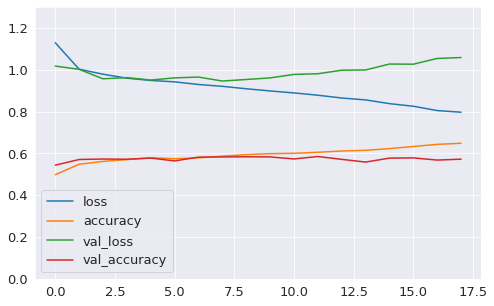

In [ ]:
def plot_history_graphs(history): # for plotting the loss and accuracy history graphs for both train and validation set
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, 1.3) # set the vertical range to [0-1.3]
  plt.show()

plot_history_graphs(history)

In [ ]:
print(cb.logs)

[2.29786635000346, 1.490160597000795, 1.8050564209988806, 1.5251740160019835, 1.336213732000033, 1.4352345739971497, 1.464642120001372, 1.4422860449994914, 1.734928295998543, 1.9325010209940956, 1.3514048500001081, 1.4829372960011824, 1.3318479710069369, 1.3377061979990685, 1.4112146029947326, 1.4930358940036967, 2.081325469996955, 2.9878222160041332, 2.6641138790000696, 1.5070540750020882, 1.5230687980001676, 1.4473879120050697, 2.498962402998586, 3.4357699649990536, 1.6943249779942562, 1.5022588779975194, 1.5163430780012277, 1.4886256919999141, 1.4493194770038826, 1.3052905610020389, 1.415526585005864, 1.435880532997544, 1.3352196969935903, 1.3450537149983575, 1.4441076570001314, 1.3202086230012355, 1.3227378829978989, 1.3578030520002358, 1.424127200996736, 1.3512925430040923, 1.332168039996759, 1.4878575960028684, 1.4503391930047655, 1.4317929030003143, 1.3720220579998568, 1.4472138929995708, 1.4210904060018947, 2.26774470199598, 2.1707338809937937, 2.4407478980065207, 1.96616238999

In [ ]:
print(sum(cb.logs)) #time taken for training(this includes time taken for training by previous model also)

707.1745703281267


## Model Evaluation

In [ ]:
loss_accuracy = pd.DataFrame(history.history)

In [ ]:
loss_accuracy

,loss,accuracy,val_loss,val_accuracy
0,1.129033,0.497833,1.017545,0.543488
1,1.002571,0.547750,1.001715,0.570583
2,0.978575,0.561583,0.956683,0.572860
3,0.959566,0.569917,0.962272,0.571949
4,0.948598,0.578917,0.950583,0.577413
5,0.941904,0.574333,0.961115,0.563752
6,0.929328,0.578500,0.964852,0.581967
7,0.920522,0.586417,0.945850,0.582878
8,0.908983,0.594000,0.953304,0.583561
9,0.898498,0.598667,0.960918,0.582878


In [ ]:
loss_accuracy.iloc[-1] # Printing the final train and validation loss and accuracy

loss            0.796779
accuracy        0.648333
val_loss        1.058322
val_accuracy    0.572177
Name: 17, dtype: float64

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
y_predictions = model2.predict(X_valid)

In [ ]:
y_predictions

array([[6.89764097e-02, 4.14303929e-01, 3.53503048e-01, 1.42218277e-01,
        2.09984034e-02],
       [1.46931014e-03, 5.85261025e-02, 4.15375441e-01, 4.67403799e-01,
        5.72254434e-02],
       [2.63347924e-02, 1.37643054e-01, 2.95085818e-01, 3.71531725e-01,
        1.69404611e-01],
       ...,
       [1.56306269e-04, 2.18965462e-03, 3.24978381e-02, 3.43088865e-01,
        6.22067273e-01],
       [1.08851045e-05, 2.81329005e-04, 1.14129120e-02, 2.98427731e-01,
        6.89867139e-01],
       [2.53056169e-01, 4.54288900e-01, 1.22311249e-01, 8.44460726e-02,
        8.58976394e-02]], dtype=float32)

In [ ]:
y_predict = []
for i in range(len(y_predictions)):
  y_predict.append(np.argmax(y_predictions[i]))

In [ ]:
print(len(y_predict))
print(len(y_valid))

4392
4392


In [ ]:
print(classification_report(y_valid, y_predict, target_names=["rating_1", "rating_2", "rating_3", "rating_4", "rating_5"]))
print(confusion_matrix(y_valid, y_predict))

              precision    recall  f1-score   support

    rating_1       0.60      0.58      0.59       292
    rating_2       0.40      0.39      0.39       399
    rating_3       0.30      0.21      0.24       463
    rating_4       0.50      0.44      0.47      1333
    rating_5       0.67      0.79      0.73      1905

    accuracy                           0.57      4392
   macro avg       0.50      0.48      0.49      4392
weighted avg       0.55      0.57      0.56      4392

[[ 170   72   16   13   21]
 [  70  154   84   58   33]
 [  20   84   95  181   83]
 [  15   44   95  591  588]
 [   7   28   31  336 1503]]


In [ ]:
#if we see the f1-score, we find 0.73 is the maximum (which belongs to class rating_5) 
#and 0.24 is minimum (which belongs to class rating_3)
print("So the best class is rating_5 and worst class is rating_3")

So the best class is rating_5 and worst class is rating_3


In [ ]:
y_predictions

array([[6.89764097e-02, 4.14303929e-01, 3.53503048e-01, 1.42218277e-01,
        2.09984034e-02],
       [1.46931014e-03, 5.85261025e-02, 4.15375441e-01, 4.67403799e-01,
        5.72254434e-02],
       [2.63347924e-02, 1.37643054e-01, 2.95085818e-01, 3.71531725e-01,
        1.69404611e-01],
       ...,
       [1.56306269e-04, 2.18965462e-03, 3.24978381e-02, 3.43088865e-01,
        6.22067273e-01],
       [1.08851045e-05, 2.81329005e-04, 1.14129120e-02, 2.98427731e-01,
        6.89867139e-01],
       [2.53056169e-01, 4.54288900e-01, 1.22311249e-01, 8.44460726e-02,
        8.58976394e-02]], dtype=float32)

In [ ]:
corresponding_probability = []
for i in range(len(y_valid)):
  corresponding_probability.append(y_predictions[i][y_valid.iloc[i]])

In [ ]:
print(len(np.array(y_valid)))
print(len(corresponding_probability))
print(len(y_predict))

4392
4392
4392


In [ ]:
data = {
    'Real_Class':np.array(y_valid),
     "Probability": corresponding_probability, 
     "Predicted_Class": y_predict
}

In [ ]:
dfi = pd.DataFrame(data)

In [ ]:
dfi[dfi["Real_Class"] == 0].sort_values(by=['Probability'], ascending=True).head(2) #the two most incorrectly classified records 

,Real_Class,Probability,Predicted_Class
4359,0,1.347176e-07,4
3357,0,9.378361e-06,4


In [ ]:
dfi[dfi["Real_Class"] == 1].sort_values(by=['Probability'], ascending=True).head(2) #the two most incorrectly classified records 

,Real_Class,Probability,Predicted_Class
3064,1,0.000012,4
4218,1,0.000147,4


In [ ]:
dfi[dfi["Real_Class"] == 2].sort_values(by=['Probability'], ascending=True).head(2) #the two most incorrectly classified records 

,Real_Class,Probability,Predicted_Class
3612,2,0.000055,0
264,2,0.000400,0


In [ ]:
dfi[dfi["Real_Class"] == 3].sort_values(by=['Probability'], ascending=True).head(2) #the two most incorrectly classified records 

,Real_Class,Probability,Predicted_Class
3837,3,0.000006,0
674,3,0.000009,0


In [ ]:
dfi[dfi["Real_Class"] == 4].sort_values(by=['Probability'], ascending=True).head(2) #the two most incorrectly classified records 

,Real_Class,Probability,Predicted_Class
1717,4,0.000102,0
1261,4,0.000187,2


# Model 3

## Model Building and Compilation

In [ ]:
# we will use results of our hyperparameter tuning
def build_model(hidden_layers = 5, n_neurons=30, learning_rate=3e-3, input_shape=[128,]):
  model = keras.models.Sequential()
  options = {"input_shape": input_shape}
  once = False
  for i in range(hidden_layers):
    model.add(keras.layers.Dense(n_neurons, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01),  **options))
    if options == {} and once == False:
      model.add(keras.layers.Dropout(rate=0.3))
      print("added once")
      once = True
    options = {}

   

  model.add(keras.layers.Dense(5, activation="softmax",  **options))

  # optimizer = keras.optimizers.SGD(learning_rate)
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return model

In [ ]:
model3 = build_model(hidden_layers = 6, n_neurons=77, learning_rate= 0.0005270791657748539)
# here we build the model where for each hidden layer appropriate number of hidden units are 77 (result of hyperparameter tuning)
# in the build model we have done l1 regularization
# we have added a dropout layer, it further helps in regularization the output in direct sense
# there the loss function is sparse_categorical_crossentropy
# we have used Adam optimizer and learning rate has been decided by hyperparameter tuning which is 0.0005270791657748539
# we have used accuracy as a metric there


added once


In [ ]:
model3.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_161 (Dense)           (None, 77)                9933      
                                                                 
 dense_162 (Dense)           (None, 77)                6006      
                                                                 
 dropout_23 (Dropout)        (None, 77)                0         
                                                                 
 dense_163 (Dense)           (None, 77)                6006      
                                                                 
 dense_164 (Dense)           (None, 77)                6006      
                                                                 
 dense_165 (Dense)           (None, 77)                6006      
                                                                 
 dense_166 (Dense)           (None, 77)              

## Model Training

In [ ]:
history = model3.fit(X_train, y_train, 
                    epochs=1000, batch_size = 32,
                    shuffle=True,
                    validation_data=(X_valid, y_valid),
                    callbacks=[cb, keras.callbacks.EarlyStopping(patience=10)]) #training the model

Epoch 1/1000
375/375 [==============================] - 2s 4ms/step - loss: 2.8739 - accuracy: 0.4450 - val_loss: 1.5064 - val_accuracy: 0.4832
Epoch 2/1000
375/375 [==============================] - 1s 4ms/step - loss: 1.3394 - accuracy: 0.4988 - val_loss: 1.2476 - val_accuracy: 0.4886
Epoch 3/1000
375/375 [==============================] - 1s 4ms/step - loss: 1.2194 - accuracy: 0.5087 - val_loss: 1.1980 - val_accuracy: 0.5002
Epoch 4/1000
375/375 [==============================] - 1s 4ms/step - loss: 1.1842 - accuracy: 0.5205 - val_loss: 1.1555 - val_accuracy: 0.5166
Epoch 5/1000
375/375 [==============================] - 1s 4ms/step - loss: 1.1644 - accuracy: 0.5238 - val_loss: 1.1429 - val_accuracy: 0.5214
Epoch 6/1000
375/375 [==============================] - 1s 4ms/step - loss: 1.1538 - accuracy: 0.5275 - val_loss: 1.1361 - val_accuracy: 0.5244
Epoch 7/1000
375/375 [==============================] - 1s 4ms/step - loss: 1.1490 - accuracy: 0.5222 - val_loss: 1.1439 - val_accuracy:

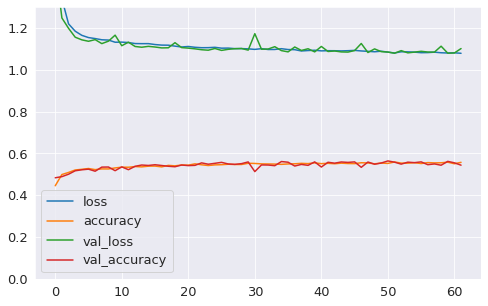

In [ ]:
def plot_history_graphs(history): # for plotting the loss and accuracy history graphs for both train and validation set
  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, 1.3) # set the vertical range to [0-1.3]
  plt.show()

plot_history_graphs(history)

In [ ]:
print(cb.logs)

[2.29786635000346, 1.490160597000795, 1.8050564209988806, 1.5251740160019835, 1.336213732000033, 1.4352345739971497, 1.464642120001372, 1.4422860449994914, 1.734928295998543, 1.9325010209940956, 1.3514048500001081, 1.4829372960011824, 1.3318479710069369, 1.3377061979990685, 1.4112146029947326, 1.4930358940036967, 2.081325469996955, 2.9878222160041332, 2.6641138790000696, 1.5070540750020882, 1.5230687980001676, 1.4473879120050697, 2.498962402998586, 3.4357699649990536, 1.6943249779942562, 1.5022588779975194, 1.5163430780012277, 1.4886256919999141, 1.4493194770038826, 1.3052905610020389, 1.415526585005864, 1.435880532997544, 1.3352196969935903, 1.3450537149983575, 1.4441076570001314, 1.3202086230012355, 1.3227378829978989, 1.3578030520002358, 1.424127200996736, 1.3512925430040923, 1.332168039996759, 1.4878575960028684, 1.4503391930047655, 1.4317929030003143, 1.3720220579998568, 1.4472138929995708, 1.4210904060018947, 2.26774470199598, 2.1707338809937937, 2.4407478980065207, 1.96616238999

In [ ]:
print(sum(cb.logs)) #time taken for training (this includes time taken for training by previous models also)

584.7798771210946


## Model Evaluation

In [ ]:
loss_accuracy = pd.DataFrame(history.history)

In [ ]:
loss_accuracy

,loss,accuracy,val_loss,val_accuracy
0,2.873927,0.445000,1.506370,0.483151
1,1.339420,0.498750,1.247603,0.488616
2,1.219371,0.508667,1.198010,0.500228
3,1.184206,0.520500,1.155533,0.516621
4,1.164397,0.523750,1.142858,0.521403
...,...,...,...,...
57,1.083920,0.554333,1.084192,0.549408
58,1.081158,0.554917,1.112533,0.543260
59,1.079924,0.557750,1.079160,0.561703
60,1.080926,0.550333,1.080201,0.554645


In [ ]:
loss_accuracy.iloc[-1] # Printing the final train and validation loss and accuracy

loss            1.078614
accuracy        0.557083
val_loss        1.101215
val_accuracy    0.543488
Name: 61, dtype: float64

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
y_predictions = model3.predict(X_valid)

In [ ]:
y_predictions

array([[1.3096365e-01, 2.7840137e-01, 2.5560641e-01, 2.4523389e-01,
        8.9794636e-02],
       [9.2273513e-03, 6.0094934e-02, 1.5878336e-01, 4.2737496e-01,
        3.4451941e-01],
       [5.3825509e-03, 4.2281743e-02, 1.3334437e-01, 4.2655995e-01,
        3.9243129e-01],
       ...,
       [9.5972355e-05, 2.7075114e-03, 2.8550988e-02, 2.9662830e-01,
        6.7201728e-01],
       [4.0932537e-05, 1.4917001e-03, 2.0031188e-02, 2.6347601e-01,
        7.1496016e-01],
       [1.7184915e-02, 8.9284807e-02, 1.9058916e-01, 4.1657212e-01,
        2.8636897e-01]], dtype=float32)

In [ ]:
y_predict = []
y_predicted_class_probability = []
for i in range(len(y_predictions)):
  y_predict.append(np.argmax(y_predictions[i]))
  y_predicted_class_probability.append(np.max(y_predictions[i]))


In [ ]:
print(len(y_predict))
print(len(y_valid))

4392
4392


In [ ]:
print(classification_report(y_valid, y_predict, target_names=["rating_1", "rating_2", "rating_3", "rating_4", "rating_5"]))
print(confusion_matrix(y_valid, y_predict))

              precision    recall  f1-score   support

    rating_1       0.61      0.59      0.60       292
    rating_2       0.44      0.34      0.38       399
    rating_3       0.00      0.00      0.00       463
    rating_4       0.37      0.26      0.31      1333
    rating_5       0.60      0.91      0.73      1905

    accuracy                           0.54      4392
   macro avg       0.40      0.42      0.40      4392
weighted avg       0.46      0.54      0.48      4392

[[ 171   75    0   37    9]
 [  85  136    0  148   30]
 [  18   63    0  232  150]
 [   8   27    0  344  954]
 [   0   11    0  158 1736]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#if we see the f1-score, we find 0.73 is the maximum (which belongs to class rating_5) 
#and 0.00 is minimum (which belongs to class rating_3)
print("So the best class is rating_5 and worst class is rating_3")

So the best class is rating_5 and worst class is rating_3


In [ ]:
y_predictions

array([[1.3096365e-01, 2.7840137e-01, 2.5560641e-01, 2.4523389e-01,
        8.9794636e-02],
       [9.2273513e-03, 6.0094934e-02, 1.5878336e-01, 4.2737496e-01,
        3.4451941e-01],
       [5.3825509e-03, 4.2281743e-02, 1.3334437e-01, 4.2655995e-01,
        3.9243129e-01],
       ...,
       [9.5972355e-05, 2.7075114e-03, 2.8550988e-02, 2.9662830e-01,
        6.7201728e-01],
       [4.0932537e-05, 1.4917001e-03, 2.0031188e-02, 2.6347601e-01,
        7.1496016e-01],
       [1.7184915e-02, 8.9284807e-02, 1.9058916e-01, 4.1657212e-01,
        2.8636897e-01]], dtype=float32)

In [ ]:
corresponding_probability = []
for i in range(len(y_valid)):
  corresponding_probability.append(y_predictions[i][y_valid.iloc[i]])

In [ ]:
print(len(np.array(y_valid)))
print(len(corresponding_probability))
print(len(y_predict))

4392
4392
4392


In [ ]:
data = {
    'Real_Class':np.array(y_valid),
     "Probability": corresponding_probability, 
     "Predicted_Class": y_predict,
     "Predicted_Class_Probability": y_predicted_class_probability
}

In [ ]:
dfi = pd.DataFrame(data)

In [ ]:
dfi

,Real_Class,Probability,Predicted_Class,Predicted_Class_Probability
0,2,0.255606,1,0.278401
1,3,0.427375,3,0.427375
2,4,0.392431,3,0.426560
3,2,0.255496,3,0.310240
4,3,0.317275,4,0.643382
...,...,...,...,...
4387,3,0.427159,3,0.427159
4388,3,0.366206,4,0.565917
4389,4,0.672017,4,0.672017
4390,3,0.263476,4,0.714960


In [ ]:
dfi[dfi["Real_Class"] == 0].sort_values(by=['Probability'], ascending=True).head(2) #the two most incorrectly classified records 

,Real_Class,Probability,Predicted_Class,Predicted_Class_Probability
4359,0,0.000026,4,0.735637
678,0,0.000037,4,0.720235


In [ ]:
dfi[dfi["Real_Class"] == 1].sort_values(by=['Probability'], ascending=True).head(2) #the two most incorrectly classified records 

,Real_Class,Probability,Predicted_Class,Predicted_Class_Probability
3064,1,0.000524,4,0.778435
4016,1,0.002843,4,0.668266


In [ ]:
dfi[dfi["Real_Class"] == 2].sort_values(by=['Probability'], ascending=True).head(2) #the two most incorrectly classified records 

,Real_Class,Probability,Predicted_Class,Predicted_Class_Probability
3622,2,0.007024,4,0.812807
2696,2,0.011759,4,0.769557


In [ ]:
dfi[dfi["Real_Class"] == 3].sort_values(by=['Probability'], ascending=True).head(2) #the two most incorrectly classified records 

,Real_Class,Probability,Predicted_Class,Predicted_Class_Probability
1730,3,0.031983,0,0.533726
13,3,0.037776,0,0.505853


In [ ]:
dfi[dfi["Real_Class"] == 4].sort_values(by=['Probability'], ascending=True).head(2) #the two most incorrectly classified records 

,Real_Class,Probability,Predicted_Class,Predicted_Class_Probability
3587,4,0.017930,1,0.368243
335,4,0.031415,1,0.359878


In [ ]:
print("end")

end


# Model Comparisions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
path1 = "/content/drive/MyDrive/ml_projects/2_nlp_task/model1.PNG"
path2 = "/content/drive/MyDrive/ml_projects/2_nlp_task/model2.PNG"
path3 = "/content/drive/MyDrive/ml_projects/2_nlp_task/model3.PNG"

def showImage(path, label):
  # read the image
  im = plt.imread(path)
  plt.xlabel(label)
  # show the image
  plt.imshow(im)
  plt.show()

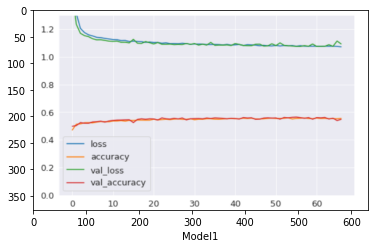

hi




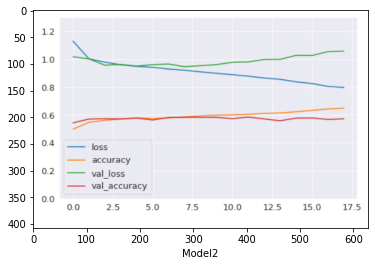

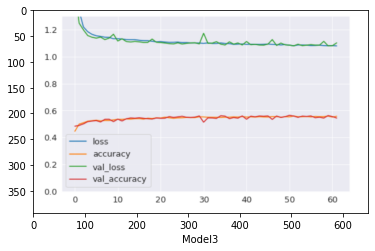

In [ ]:
showImage(path1, "Model1")
showImage(path2, "Model2")
showImage(path3, "Model3")



In [ ]:
# in model1 the training loss and validation loss is quite similar, its accuracy is .55, here the dropout rate is .2
# in model2 the training loss is significantly lower than the validation loss, this means that the dataset has overfitted on
# the training set. As is evident by the fact that in model2 we removed regularization that was applied in model1
# in model3 the accuracy on the validation set is .54 and the dropout rate is .3 => also due to more dropout rate their is
# slight decrease in accuracy as compared to model1